In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from scipy.integrate import ode
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_C_sqrt import CAdaptive_C_RK4_NL_sqrt
from adaptive_GC_sqrt import CAdaptive_GC_RK4_NL_sqrt

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def gc_exact_single_step(rho_, *, h1e, mf, beta, inv_ovlp, ovlp, mu, **kwargs):
    h = h1e + mf.get_veff(mf.mol, rho_)
    rho = ovlp @ linalg.funm(inv_ovlp @ h, 
                    lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))
    return rho

def c_exact_single_step(rho_, *, h1e, mf, beta, inv_ovlp, ovlp, mu, num_electrons, **kwargs):
    h = h1e + mf.get_veff(mf.mol, rho_)
    rho = ovlp @ linalg.funm(inv_ovlp @ h, 
                             lambda _: np.exp(-beta*(_ - mu))/(1+np.exp(-beta*(_ - mu))))
    rho *= num_electrons/rho.trace()
    return rho

def aitkens(rho, nsteps, single_step_func, **func_args):
    """
    function for performing the Aitken's delta-squared convergence method
    :param rho:                 the density matrix to start the convergence with
    :param nsteps:              the number of steps to try converging for
    :param single_step_func:    the function that generates the next density matrix
    :param func_args:           the extra arguments for the single step function
    :return:                    the converged density matrix and the norm differences
    """
    norm_diff = []
    rho_0 = rho.copy()
    for i in range(nsteps):
        prev_aitken_rho = rho_0.copy()
        rho_1 = single_step_func(rho_0, **func_args)
        rho_2 = single_step_func(rho_1, **func_args)

        aitken_rho = rho_2 - (rho_2 - rho_1) ** 2 / ma.array(rho_2 - 2 * rho_1 + rho_0)
        aitken_rho = ma.filled(aitken_rho, fill_value=rho_2)

        rho_0 = aitken_rho

        norm_diff.append(linalg.norm(aitken_rho - prev_aitken_rho))

        if np.allclose(aitken_rho, prev_aitken_rho) and i > 5:
            print("Iterations converged!")
            break

    return aitken_rho, norm_diff

converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.0272972299461 occ= 2
MO #3 (A1 #3), energy= -0.426131190105551 occ= 2
MO #4 (E1x #1), energy= -0.28993852061284 occ= 2
MO #5 (E1y #1), energy= -0.289938520612841 occ= 2
MO #6 (A1 #4), energy= -0.0349559135896425 occ= 0
MO #7 (A1 #5), energy= 0.66467504929875 occ= 0
MO #8 (E1x #2), energy= 1.1305709354121 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513673 occ= 0
MO #11 (A1 #7), energy= 1.57280313485609 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.29132770625063
Chemical Potential:  -0.16244721710124183
DFT trace:  7.124009715257128
Core eigvals:  [-40

Text(0.5, 1.0, 'Overlap Matrix Elements')

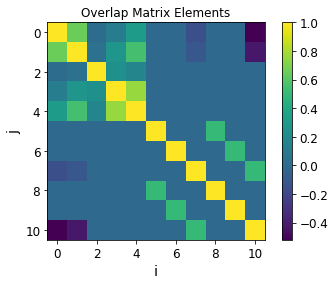

In [4]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
dft_mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
print('Chemical Potential: ', str(dft_mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
inv_ovlp = linalg.inv(ovlp)

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())
core_spect = linalg.eigvalsh(h1e, ovlp)
print("Core eigvals: ", core_spect)
num_electrons = 10
index = int(num_electrons/2)
gcp_mu = (core_spect[index] + core_spect[index-1])/2
plt.imshow(ovlp)
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.title('Overlap Matrix Elements')

In [5]:
# initialize beta and dbeta
beta = 3
dbeta = beta / 10000

### Grand Canonical

In [6]:
# Create class for GC sqrt method (non-linear)
gc = CAdaptive_GC_RK4_NL_sqrt(ovlp=ovlp, H=h1e, mu=dft_mu, mf=mf, dbeta=dbeta)
gc.propagate(beta)

array([[ 2.47540524e-01+0.j,  2.09133609e-01+0.j,  1.85448085e-04+0.j,
         6.01064804e-02+0.j,  1.07097180e-01+0.j, -5.73194086e-18+0.j,
        -3.95497489e-19+0.j, -9.43454639e-02+0.j, -6.69826860e-18+0.j,
         4.12978640e-20+0.j, -1.60693041e-01+0.j],
       [ 2.67107782e-01+0.j,  4.27317687e-01+0.j,  1.10584658e-02+0.j,
         1.19551100e-01+0.j,  2.14772305e-01+0.j, -9.42303210e-17+0.j,
         6.05124392e-18+0.j, -4.06771336e-02+0.j, -8.27975503e-17+0.j,
         6.28939694e-18+0.j, -1.41587095e-01+0.j],
       [-5.97880569e-03+0.j,  6.48367749e-03+0.j,  9.91223773e-01+0.j,
         1.19711216e-01+0.j,  6.37172517e-02+0.j, -7.94017498e-17+0.j,
         4.13029457e-18+0.j, -2.12088860e-03+0.j, -8.73878423e-17+0.j,
        -1.61742853e-17+0.j, -2.13683981e-03+0.j],
       [ 9.98491608e-02+0.j,  2.10754716e-01+0.j,  1.13344561e-01+0.j,
         7.55000450e-01+0.j,  6.27913909e-01+0.j,  1.71814349e-17+0.j,
        -9.31431582e-18+0.j,  1.57773030e-02+0.j, -1.35017215e-16+

In [7]:
# Calculate exact fermi dirac distribution
func_args = {'h1e': h1e, 'mf': mf, 'mu': dft_mu, 'ovlp': ovlp, 
             'inv_ovlp': inv_ovlp, 'beta': gc.beta}
ferm_exact, norm_diff = aitkens(ovlp / 2, 50, gc_exact_single_step, **func_args)

funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.00019863555351953466
funm result may be inaccurate, approximate err = 0.003048914271400006
funm result may be inaccurate, approximate err = 3.04039264915582e-08
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 7.21903282507645e-05
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1.6731738723949016e-05
funm result may be inaccurate, approximate err = 0.0006950277150362506
funm result may be inaccurate, approximate err = 1.60589150338442e-05
funm result may be inaccurate, approximate err = 0.0003959373754859995
funm result may be inaccurate, approximate err = 0.00016985070118206384
funm result may be inaccurate, approximate err = 0.001776801581890708
funm result may be inaccurate, approximate err = 0.00045115274899569627
funm result may 

3.0031071318518574


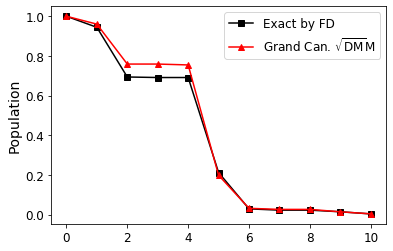

In [21]:
rho = gc.omega.conj().T @ gc.omega
print(gc.beta)
plt.plot(linalg.eigvalsh(ferm_exact, ovlp)[::-1], 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(rho, ovlp)[::-1], 'r^-', label="Grand Can. $\\sqrt{\\mathrm{DM}}$M")
#plt.xlabel("Eigenvalue Index")
plt.ylabel("Population")
plt.legend(numpoints=1)
plt.savefig("gc_hf_eigs_adptsqrt.png", format='png', dpi=300)

/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Energy')

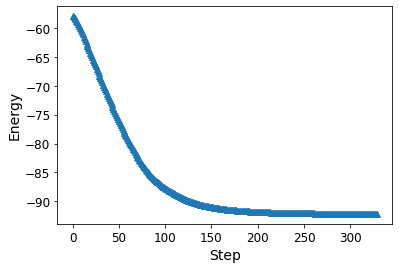

In [9]:
plt.plot(gc.energy_vals, '^-')
plt.xlabel("Step")
plt.ylabel("Energy")

### Canonical

In [10]:
c = CAdaptive_C_RK4_NL_sqrt(ovlp=ovlp, H=h1e, num_electrons=mol.nelectron, dbeta=dbeta, mf=mf)
c.propagate(beta)

Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next >

Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next > energy
Energy_next >

array([[ 3.41788661e-01+0.j,  2.63671468e-01+0.j, -7.29726039e-04+0.j,
         8.10523427e-02+0.j,  1.43946940e-01+0.j,  1.68589005e-17+0.j,
         3.30605634e-18+0.j, -8.46697935e-02+0.j, -3.94480660e-18+0.j,
        -6.93672344e-19+0.j, -1.94240046e-01+0.j],
       [ 5.35664223e-01+0.j,  1.15288464e+00+0.j,  1.47661273e-02+0.j,
         1.19660309e-01+0.j,  3.75138818e-01+0.j,  1.21479376e-16+0.j,
         3.32811113e-17+0.j, -1.44213530e-02+0.j, -2.93890920e-17+0.j,
         6.49367981e-19+0.j, -2.64294368e-01+0.j],
       [-5.94358266e-03+0.j,  1.56413797e-02+0.j,  1.33516497e+00+0.j,
         2.15896712e-01+0.j,  1.00618925e-01+0.j,  3.34469002e-16+0.j,
        -3.36008228e-17+0.j, -8.82627648e-03+0.j, -9.78570439e-17+0.j,
         1.30454020e-17+0.j, -1.52440650e-02+0.j],
       [ 1.07269037e-01+0.j,  1.86065998e-01+0.j,  1.69247167e-01+0.j,
         5.91628197e-01+0.j,  5.92026809e-01+0.j,  1.39951775e-16+0.j,
         8.21812478e-18+0.j,  3.60348824e-02+0.j, -6.32362008e-17+

(10.000000006563928+0j)
3.000357690861355


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


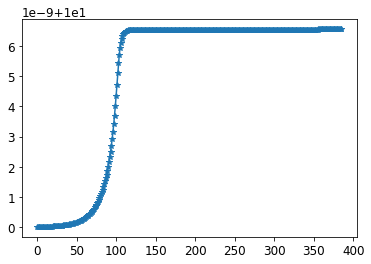

In [11]:
plt.plot(c.num_electron_list, '*-')
print(np.trace(c.omega.conj().T @ c.omega))
print(c.beta)

In [12]:
# Calculate exact fermi dirac distribution
coeff = 2 * c.num_electrons / ovlp.trace()
func_args = {'h1e': h1e, 'mf': mf, 'mu': c.mu, 'ovlp': ovlp,
             'inv_ovlp': inv_ovlp, 'beta': c.beta, 'num_electrons':c.num_electrons}
c_ferm_exact, c_norm_diff = aitkens(coeff * ovlp, 50, c_exact_single_step, **func_args)

funm result may be inaccurate, approximate err = 0.8275703130128136
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.7201562050300337
funm result may be inaccurate, approximate err = 9.854017062411063e-11
funm result may be inaccurate, approximate err = 0.0008470246942992642
funm result may be inaccurate, approximate err = 3.477679294719552e-11
funm result may be inaccurate, approximate err = 3.263057878584119e-10
funm result may be inaccurate, approximate err = 1.4169446505477766e-11
funm result may be inaccurate, approximate err = 1.310467243589445e-08
funm result may be inaccurate, approximate err = 6.77038865953985e-10
funm result may be inaccurate, approximate err = 6.015442554631292e-09
funm result may be inaccurate, approximate err = 6.818785525243178e-10
funm result may be inaccurate, approximate err = 5.186100761252491e-09
funm result may be inaccurate, approximate err = 3.8

3.000357690861355


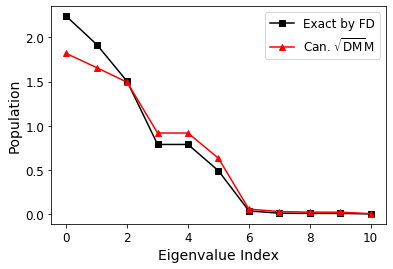

In [20]:
c_rho = c.omega.conj().T @ c.omega
print(c.beta)
plt.plot(linalg.eigvalsh(c_ferm_exact, ovlp)[::-1], 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(c_rho, ovlp)[::-1], 'r^-', label="Can. $\\sqrt{\\mathrm{DM}}$M")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Population")
plt.legend(numpoints=1)
plt.savefig("c_hf_eigs_adptsqrt.png", format='png', dpi=300)

/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Energy')

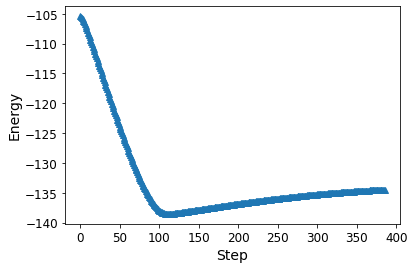

In [14]:
plt.plot(c.energy_vals, '^-')
plt.xlabel("Step")
plt.ylabel("Energy")